In [54]:
%load_ext autoreload
%autoreload 2


from IPython.display import display, HTML
from agents import banditagents
from environments import bandits
import utils

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
sns.set_theme(style="whitegrid", palette="pastel")
figures_dir = os.path.join(os.getcwd(), 'figures')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
#np.random.seed(seed=0)
alpha = 0.6
num_episodes = 40 #40
num_iterations = 500
observe_best_arm = True
save_all_iterations = True
configs_dir = '/Users/juliomartinez/Documents/PhD/socialmotivation/configs'
solvers = ['Greedy', 'EpsilonGreedy', 'UCB', 'Thompson']
#solvers = ['Thompson']
test_alphas = True



#environment = 'TwoArmBandit'
#bandit_config_filename = os.path.join(configs_dir, environment + '.yaml')
#bandit_config = utils.get_config(bandit_config_filename)
#env = bandits.Bandit(bandit_config)



increment = 0.05
alphas = np.round(np.arange(0.5,1 + increment,increment), 3)
all_num_arms = [2,4,8,16,32,64, 128]

if test_alphas:
    payoff_cases = alphas
else:
    payoff_cases = all_num_arms

for k, case in enumerate(payoff_cases):
    
    if test_alphas:
        alpha = case
        payoffs = np.sort([alpha, round((1.0-alpha) / increment) * increment])[::-1]
        print('alpha:', alpha)
        print('payoffs:', payoffs)
        num_arms = len(payoffs)
        bandit_config = {'payoffs':payoffs, 'sampling_distribution':'uniform'}
        env = bandits.Bandit(bandit_config)
    else:
        num_arms = case
        alpha = None
        print('num_arms:', num_arms)
        payoffs = np.sort(np.squeeze(np.random.dirichlet(np.ones(num_arms),size=1)))[::-1]
        bandit_config = {'payoffs':payoffs, 'sampling_distribution':'uniform'}
        env = bandits.Bandit(bandit_config)

    #np.random.seed(seed=3)
    for i, solver in enumerate(solvers):
        
    
        # Get solver class 
        agentClass = getattr(banditagents, solver)
        
        # Get config file
        agents_config_filename = os.path.join(configs_dir, solver + 'Agent.yaml')
        agents_config = utils.get_config(agents_config_filename)
        agents_config['learner']['observe_best_arm'] = observe_best_arm

        demonstrator_best_arm_distribution = np.zeros(env.num_arms)
        learner_best_arm_distribution = np.zeros(env.num_arms)

        best_arm_id_count = 0
        other_arm_id_count = 0
        
        for episode_j in range(num_episodes):
            # run demonstrator
            demonstrator = agentClass(agents_config['demonstrator'])   
            demonstrator(env)
            
            # run learner
            learner = agentClass(agents_config['learner'])
            learner(env, demonstrator)

            # compute stats
            demonstrator_cumsum = np.cumsum(demonstrator.reward_history)
            learner_cumsum = np.cumsum(learner.reward_history)
            learner_delta_cumsum = learner_cumsum - demonstrator_cumsum
            demonstrator_delta_cumsum =  -learner_delta_cumsum 

            if episode_j == 0:
                all_episodes_learner_arm_id_history = np.array(learner.reward_history)
                all_episodes_demonstrator_arm_id_history = np.array(demonstrator.reward_history)
            else:
                all_episodes_learner_arm_id_history = np.hstack((all_episodes_learner_arm_id_history, np.array(learner.reward_history)))
                all_episodes_demonstrator_arm_id_history = np.hstack((all_episodes_demonstrator_arm_id_history, np.array(demonstrator.reward_history)))


            # propertion of time best arm is chosen
            learner_prop_best_arm = np.mean(all_episodes_learner_arm_id_history == 0,axis=1)
            demonstrator_prop_best_arm = np.mean(all_episodes_demonstrator_arm_id_history == 0,axis=1)
            # proportion of time observe is chosen
            learner_prop_observe = np.mean(all_episodes_learner_arm_id_history == 2,axis=1)
            demonstrator_prop_observe = np.mean(all_episodes_demonstrator_arm_id_history == 2,axis=1)
            # proportion of time alternative arm is chosen
            learner_prop_other = 1 - learner_prop_best_arm - learner_prop_observe
            demonstrator_prop_other = 1 - demonstrator_prop_best_arm - demonstrator_prop_observe

            data = {
                'solver': np.repeat(solver,2*num_iterations),
                'episode': np.repeat(episode_j,2*num_iterations),
                'iteration': np.tile(np.arange(num_iterations),2),
                'agent': np.concatenate((['learner']*num_iterations,['demonstrator']*num_iterations)),
                'reward':  np.concatenate((learner.reward_history,demonstrator.reward_history)),
                'cumulative_reward': np.concatenate((learner_cumsum, demonstrator_cumsum)),
                'delta_cumulative_reward': np.concatenate((learner_delta_cumsum,demonstrator_delta_cumsum)),
                'chosen_arm_id': np.concatenate((learner.arm_id_history,demonstrator.arm_id_history)),
                'alpha': np.repeat(alpha,2*num_iterations),
                'num_arms': np.repeat(num_arms,2*num_iterations),
                'proportion_best_arm': np.concatenate((learner_prop_best_arm,demonstrator_prop_best_arm)),
                'proportion_observe': np.concatenate((learner_prop_observe,demonstrator_prop_observe)),
                'proportion_other': np.concatenate((learner_prop_other,demonstrator_prop_other)),
                }
            episode_df = pd.DataFrame.from_dict(data)
            if k < 1 and i < 1 and episode_j < 1:
                results_long_df = episode_df.copy()
            else:
                results_long_df = pd.concat([results_long_df,episode_df],join='inner', ignore_index=True)

results_long_df = results_long_df.sort_values(by=['solver', 'episode', 'iteration'], ignore_index=True)
results_long_df.to_csv('/Users/juliomartinez/Documents/PhD/socialmotivation/results.csv')
display(HTML(results_long_df.head().to_html()))

learner_results_long_df = results_long_df.groupby('agent').get_group('learner')

alpha: 0.5
payoffs: [0.5 0.5]
alpha: 0.55
payoffs: [0.55 0.45]
alpha: 0.6
payoffs: [0.6 0.4]
alpha: 0.65
payoffs: [0.65 0.35]
alpha: 0.7
payoffs: [0.7 0.3]
alpha: 0.75
payoffs: [0.75 0.25]
alpha: 0.8
payoffs: [0.8 0.2]
alpha: 0.85
payoffs: [0.85 0.15]
alpha: 0.9
payoffs: [0.9 0.1]
alpha: 0.95
payoffs: [0.95 0.05]
alpha: 1.0
payoffs: [1. 0.]


,solver,episode,iteration,agent,reward,cumulative_reward,delta_cumulative_reward,chosen_arm_id,alpha,num_arms
0,EpsilonGreedy,0,0,learner,0.0,0.0,-1.0,2,0.50,2
1,EpsilonGreedy,0,0,demonstrator,1.0,1.0,1.0,0,0.50,2
2,EpsilonGreedy,0,0,learner,0.0,0.0,0.0,1,0.55,2
3,EpsilonGreedy,0,0,demonstrator,0.0,0.0,-0.0,0,0.55,2
4,EpsilonGreedy,0,0,learner,0.0,0.0,-1.0,2,0.60,2


In [ ]:
alpha = 0.6
episode = 39
alpha_learner_results_long_df = learner_results_long_df.groupby(['alpha', 'episode']).get_group((alpha, episode))

alpha_learner_arm_proprtion_results_long_df = alpha_learner_results_long_df['solver', 'iteration', 'proportion_best_arm', 'proportion_observe', 'proportion_other']
alpha_learner_arm_proprtion_results_melt_df = pd.melt(
    alpha_learner_arm_proprtion_results_long_df, 
    id_vars=['solver', 'iteration'], 
    value_vars=['proportion_best_arm', 'proportion_observe', 'proportion_other'],
    var_name='proportion_type',
    value_name='proportion')
sns.lineplot(data=learner_results_long_df, x="iteration", y="proportion", hue="solver", style='proportion_type')

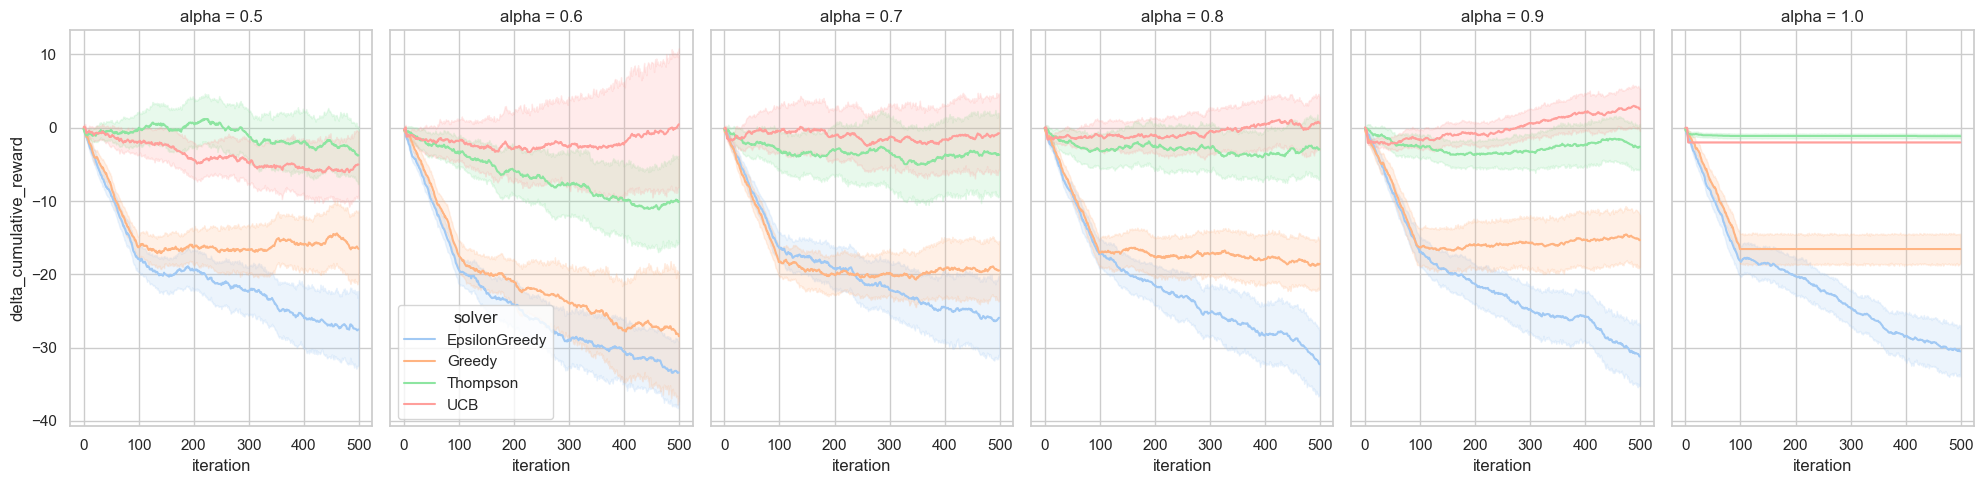

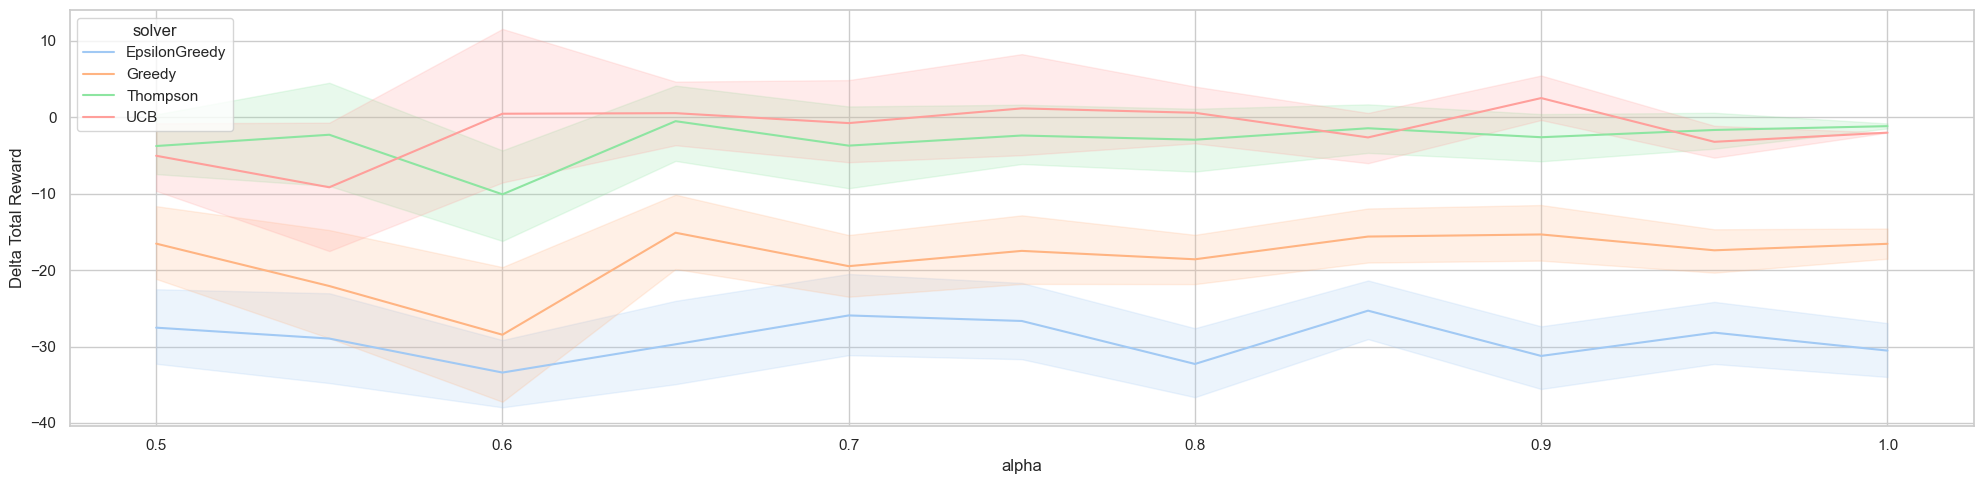

In [17]:
if test_alphas:
    fig, axs = plt.subplots(nrows=1, ncols=len(alphas[::2]), sharex=False, sharey=True, figsize=(20,5))
    for i, alpha in enumerate(alphas[::2]):
        legend = None
        if i==1:
            legend = 'auto'
        alpha_learner_results_long_df = learner_results_long_df.groupby('alpha').get_group(alpha)
        sns.lineplot(data=alpha_learner_results_long_df, x="iteration", y="delta_cumulative_reward", hue="solver",ax=axs[i], legend=legend)
        axs[i].set_title('alpha = ' + str(alpha))
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir,'delta_cumulative_reward_per_alpha.png'),bbox_inches="tight")
    plt.show()

    fig = plt.figure(figsize=(20,5))
    sns.lineplot(data=learner_results_long_df[learner_results_long_df['iteration'] == num_iterations-1], x="alpha", y="delta_cumulative_reward", hue="solver")
    #plt.title('Varying payoff probability alpha, $(p_{arm1} = \\alpha, p_{arm2} = 1-\\alpha)$')
    plt.ylabel('Delta Total Reward')
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir,'delta_total_reward_per_alpha.png'), bbox_inches="tight")
    plt.show()
else:
    fig, axs = plt.subplots(nrows=1, ncols=len(all_num_arms), sharex=False, sharey=True, figsize=(20,5))
    for i, num_arms in enumerate(all_num_arms):
        legend = None
        if i==1:
            legend = 'auto'
        alpha_learner_results_long_df = learner_results_long_df.groupby('num_arms').get_group(num_arms)
        sns.lineplot(data=alpha_learner_results_long_df, x="iteration", y="delta_cumulative_reward", hue="solver",ax=axs[i], legend=legend)
        axs[i].set_ylabel('Delta Cumulative Reward')
        axs[i].set_title('num_arms = ' + str(num_arms))
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir,'delta_cumulative_reward_per_num_arms.png'), bbox_inches="tight")
    plt.show()

    fig = plt.figure(figsize=(20,5))
    sns.lineplot(data=learner_results_long_df[learner_results_long_df['iteration'] == num_iterations-1], x="num_arms", y="delta_cumulative_reward", hue="solver")
    plt.xticks(all_num_arms, all_num_arms)
    plt.ylabel('Delta Total Reward')
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir,'delta_total_reward_per_num_arms.png'), bbox_inches="tight")
    plt.show()

In [74]:
#np.random.seed(seed=0)
alpha = 0.6
num_episodes = 40 #40
num_iterations = 500
observe_best_arm = True
save_all_iterations = True
configs_dir = '/Users/juliomartinez/Documents/PhD/socialmotivation/configs'
#solvers = ['Greedy', 'EpsilonGreedy', 'UCB', 'Thompson']
solvers = ['ThompsonTrust']
test_alphas = True

TrustSolvers = ['ThompsonTrust']
NonTrustSolvers = [solver[:-5] for solver in TrustSolvers]

#environment = 'TwoArmBandit'
#bandit_config_filename = os.path.join(configs_dir, environment + '.yaml')
#bandit_config = utils.get_config(bandit_config_filename)
#env = bandits.Bandit(bandit_config)


increment = 0.05
alphas = np.round(np.arange(0.5,1 + increment,increment), 3)
all_num_arms = [2,4,8,16,32,64, 128]

trust_distrutions = [(1.0, 0.0),(0.25, 0.025), (0.5, 0.025), (0.95, 0.025), (0.95, 0.05), (0.85,0.1)]

if test_alphas:
    payoff_cases = alphas
else:
    payoff_cases = all_num_arms

for k, case in enumerate(payoff_cases):
    
    if test_alphas:
        alpha = case
        payoffs = np.sort([alpha, round((1.0-alpha) / increment) * increment])[::-1]
        print('alpha:', alpha)
        print('payoffs:', payoffs)
        num_arms = len(payoffs)
        bandit_config = {'payoffs':payoffs, 'sampling_distribution':'uniform'}
        env = bandits.Bandit(bandit_config)
    else:
        num_arms = case
        alpha = None
        print('num_arms:', num_arms)
        payoffs = np.sort(np.squeeze(np.random.dirichlet(np.ones(num_arms),size=1)))[::-1]
        bandit_config = {'payoffs':payoffs, 'sampling_distribution':'uniform'}
        env = bandits.Bandit(bandit_config)

    #np.random.seed(seed=3)
    for i, solver in enumerate(solvers):

        if solver in TrustSolvers:
            learnerSolver = solver
            for nontrustsolver in NonTrustSolvers:
                if nontrustsolver in learnerSolver:
                    demonstratorSolver = nontrustsolver
                    break
        else:
            learnerSolver = solver
            demonstratorSolver = solver
        
        # Get solver class 
        demonstratorAgentClass = getattr(banditagents, demonstratorSolver)
        learnerAgentClass = getattr(banditagents, learnerSolver)
        
        # Get config file
        agents_config_filename = os.path.join(configs_dir, solver + 'Agent.yaml')
        agents_config = utils.get_config(agents_config_filename)
        agents_config['learner']['observe_best_arm'] = observe_best_arm
        

        demonstrator_best_arm_distribution = np.zeros(env.num_arms)
        learner_best_arm_distribution = np.zeros(env.num_arms)

        for l, (p_trust, p_obs) in enumerate(trust_distrutions):
            if i==0:
                print('p_trust:', p_trust, 'p_obs:', p_obs)
            agents_config['learner']['prob_trust'] = p_trust
            agents_config['learner']['prob_observe'] = p_obs

            for episode_j in range(num_episodes):
                # run demonstrator
                demonstrator = demonstratorAgentClass(agents_config['demonstrator'])   
                demonstrator(env)
                
                # run learner
                learner = learnerAgentClass(agents_config['learner'])
                learner(env, demonstrator)

                # compute stats
                demonstrator_cumsum = np.cumsum(demonstrator.reward_history)
                learner_cumsum = np.cumsum(learner.reward_history)
                learner_delta_cumsum = learner_cumsum - demonstrator_cumsum
                demonstrator_delta_cumsum =  -learner_delta_cumsum 

                data = {
                    'solver': np.repeat(solver,2*num_iterations),
                    'episode': np.repeat(episode_j,2*num_iterations),
                    'iteration': np.tile(np.arange(num_iterations),2),
                    'agent': np.concatenate((['learner']*num_iterations,['demonstrator']*num_iterations)),
                    'reward':  np.concatenate((learner.reward_history,demonstrator.reward_history)),
                    'cumulative_reward': np.concatenate((learner_cumsum, demonstrator_cumsum)),
                    'delta_cumulative_reward': np.concatenate((learner_delta_cumsum,demonstrator_delta_cumsum)),
                    'chosen_arm_id': np.concatenate((learner.arm_id_history,demonstrator.arm_id_history)),
                    'alpha': np.repeat(alpha,2*num_iterations),
                    'num_arms': np.repeat(num_arms,2*num_iterations),
                    'trust_distr': np.repeat('p_trust: {}, p_obs: {}'.format(learner.p_greedytrust, learner.p_observe),2*num_iterations),
                    }
                episode_df = pd.DataFrame.from_dict(data)
                if k < 1 and i < 1 and episode_j < 1 and l < 1:
                    results_long_df = episode_df.copy()
                else:
                    results_long_df = pd.concat([results_long_df,episode_df],join='inner', ignore_index=True)

results_long_df = results_long_df.sort_values(by=['solver', 'episode', 'iteration'], ignore_index=True)
results_long_df.to_csv('/Users/juliomartinez/Documents/PhD/socialmotivation/results.csv')
display(HTML(results_long_df.head().to_html()))

learner_results_long_df = results_long_df.groupby('agent').get_group('learner')

alpha: 0.5
payoffs: [0.5 0.5]
p_trust: 1.0 p_obs: 0.0
p_trust: 0.25 p_obs: 0.025
p_trust: 0.5 p_obs: 0.025
p_trust: 0.95 p_obs: 0.025
p_trust: 0.95 p_obs: 0.05
p_trust: 0.85 p_obs: 0.1
alpha: 0.55
payoffs: [0.55 0.45]
p_trust: 1.0 p_obs: 0.0
p_trust: 0.25 p_obs: 0.025
p_trust: 0.5 p_obs: 0.025
p_trust: 0.95 p_obs: 0.025
p_trust: 0.95 p_obs: 0.05
p_trust: 0.85 p_obs: 0.1
alpha: 0.6
payoffs: [0.6 0.4]
p_trust: 1.0 p_obs: 0.0
p_trust: 0.25 p_obs: 0.025
p_trust: 0.5 p_obs: 0.025
p_trust: 0.95 p_obs: 0.025
p_trust: 0.95 p_obs: 0.05
p_trust: 0.85 p_obs: 0.1
alpha: 0.65
payoffs: [0.65 0.35]
p_trust: 1.0 p_obs: 0.0
p_trust: 0.25 p_obs: 0.025
p_trust: 0.5 p_obs: 0.025
p_trust: 0.95 p_obs: 0.025
p_trust: 0.95 p_obs: 0.05
p_trust: 0.85 p_obs: 0.1
alpha: 0.7
payoffs: [0.7 0.3]
p_trust: 1.0 p_obs: 0.0
p_trust: 0.25 p_obs: 0.025
p_trust: 0.5 p_obs: 0.025
p_trust: 0.95 p_obs: 0.025
p_trust: 0.95 p_obs: 0.05
p_trust: 0.85 p_obs: 0.1
alpha: 0.75
payoffs: [0.75 0.25]
p_trust: 1.0 p_obs: 0.0
p_trust: 0.2

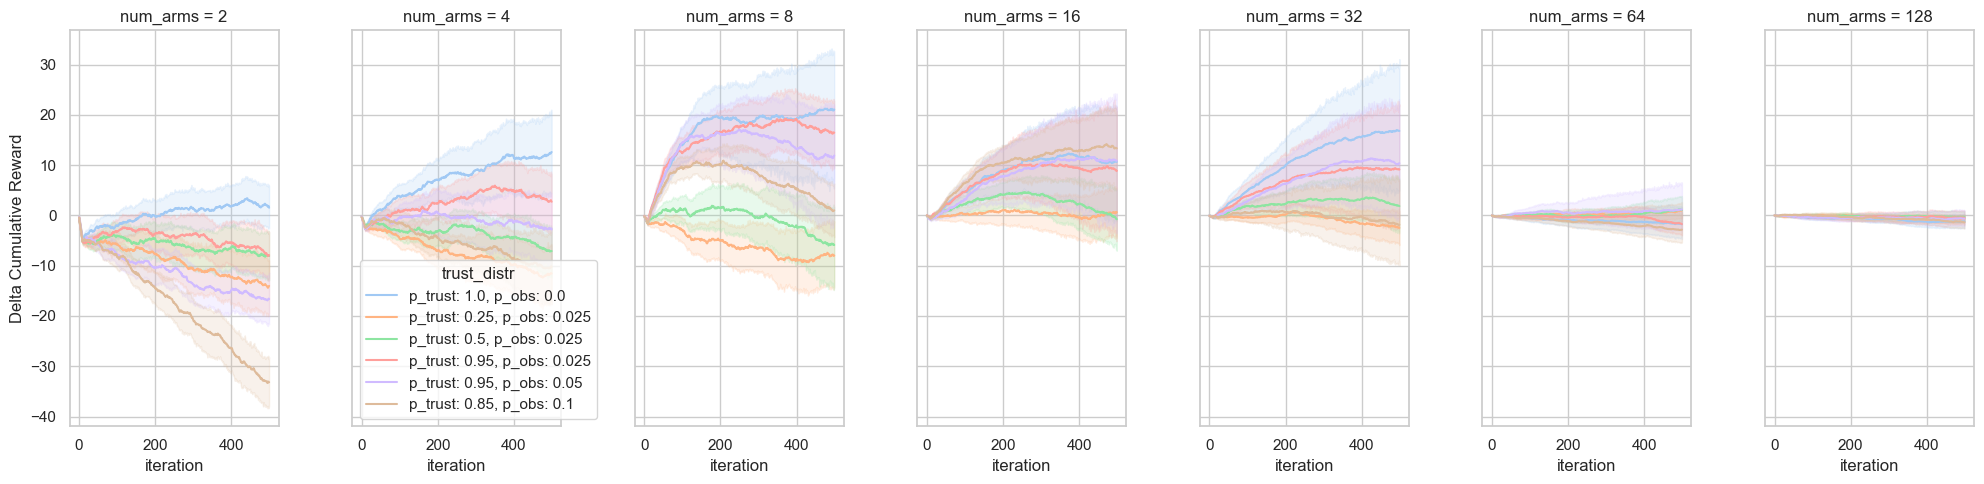

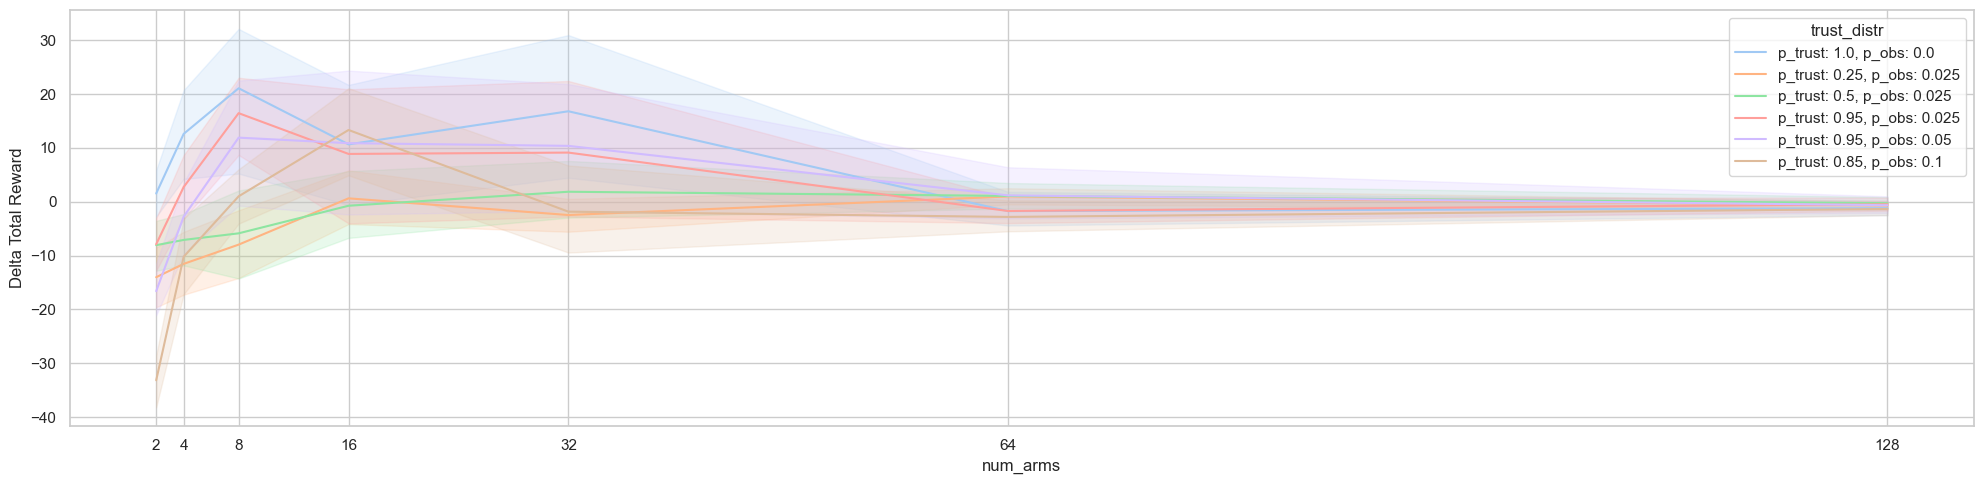

In [73]:
# one set of plots comparing the number of different initial iterations
# another set of plots comparing the number of different p_trust and p_obs
# both over different number of arms
# and differernt alphas

if test_alphas:
    fig, axs = plt.subplots(nrows=1, ncols=len(alphas[::2]), sharex=False, sharey=True, figsize=(20,5))
    for i, alpha in enumerate(alphas[::2]):
        legend = None
        if i==1:
            legend = 'auto'
        alpha_learner_results_long_df = learner_results_long_df.groupby('alpha').get_group(alpha)
        sns.lineplot(data=alpha_learner_results_long_df, x="iteration", y="delta_cumulative_reward", hue="trust_distr",ax=axs[i], legend=legend)
        axs[i].set_title('alpha = ' + str(alpha))
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir,'delta_cumulative_reward_per_alpha.png'),bbox_inches="tight")
    plt.show()

    fig = plt.figure(figsize=(20,5))
    sns.lineplot(data=learner_results_long_df[learner_results_long_df['iteration'] == num_iterations-1], x="alpha", y="delta_cumulative_reward", hue="trust_distr")
    #plt.title('Varying payoff probability alpha, $(p_{arm1} = \\alpha, p_{arm2} = 1-\\alpha)$')
    plt.ylabel('Delta Total Reward')
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir,'delta_total_reward_per_alpha.png'), bbox_inches="tight")
    plt.show()
else:
    fig, axs = plt.subplots(nrows=1, ncols=len(all_num_arms), sharex=False, sharey=True, figsize=(20,5))
    for i, num_arms in enumerate(all_num_arms):
        legend = None
        if i==1:
            legend = 'auto'
        num_arms_learner_results_long_df = learner_results_long_df.groupby('num_arms').get_group(num_arms)
        sns.lineplot(data=num_arms_learner_results_long_df, x="iteration", y="delta_cumulative_reward", hue="trust_distr",ax=axs[i], legend=legend)
        axs[i].set_ylabel('Delta Cumulative Reward')
        axs[i].set_title('num_arms = ' + str(num_arms))
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir,'delta_cumulative_reward_per_num_arms.png'), bbox_inches="tight")
    plt.show()

    fig = plt.figure(figsize=(20,5))
    sns.lineplot(data=learner_results_long_df[learner_results_long_df['iteration'] == num_iterations-1], x="num_arms", y="delta_cumulative_reward", hue="trust_distr")
    plt.xticks(all_num_arms, all_num_arms)
    plt.ylabel('Delta Total Reward')
    plt.tight_layout()
    plt.savefig(os.path.join(figures_dir,'delta_total_reward_per_num_arms.png'), bbox_inches="tight")
    plt.show()

In [63]:
learner_results_long_df.groupby('num_arms').get_group(128).trust_distr.unique()

array(['p_trust: 1.0, p_obs: 0.0', 'p_trust: 0.25, p_obs: 0.025',
       'p_trust: 0.5, p_obs: 0.025', 'p_trust: 0.95, p_obs: 0.025',
       'p_trust: 0.95, p_obs: 0.05', 'p_trust: 0.85, p_obs: 0.1'],
      dtype=object)

In [71]:
results_long_df.groupby('num_arms').get_group(2).trust_distr.unique()

array(['p_trust: 1.0, p_obs: 0.0', 'p_trust: 0.25, p_obs: 0.025',
       'p_trust: 0.5, p_obs: 0.025', 'p_trust: 0.95, p_obs: 0.025',
       'p_trust: 0.95, p_obs: 0.05', 'p_trust: 0.85, p_obs: 0.1'],
      dtype=object)

# Deprecated Below

##  Run Solvers

In [ ]:
num_episodes = 40
num_iterations = 500
configs_dir = '/Users/juliomartinez/Documents/PhD/socialmotivation/configs'
solvers = ['Greedy', 'EpsilonGreedy', 'UCB']
environment = 'TwoArmBandit'
bandit_config_filename = os.path.join(configs_dir, environment + '.yaml')
bandit_config = utils.get_config(bandit_config_filename)
env = bandits.Bandit(bandit_config)


results_column_names = ['episode','iteration','solver','reward_demonstrator','reward_learner','chosen_arm_id_demonstrator','chosen_arm_id_learner']
#results_column_name = ['episode', 'iteration', 'solver', 'agent', 'reward', 'best_arm_id']
#best_arm_dist_column_names = ['solver', 'num_episodes', 'num_iterations', 'prob_arm1', 'prob_arm2']

np.random.seed(seed=3) # seed 3 > 4 > 2
for i, solver in enumerate(solvers):
 
    # Get solver class 
    agentClass = getattr(banditagents, solver)
    
    # Get config file
    agents_config_filename = os.path.join(configs_dir, solver + 'Agent.yaml')
    agents_config = utils.get_config(agents_config_filename)

    demonstrator_best_arm_distribution = np.zeros(env.num_arms)
    learner_best_arm_distribution = np.zeros(env.num_arms)

    for episode_j in range(num_episodes):
        # run demonstrator
        demonstrator = agentClass(agents_config['demonstrator'])   
        demonstrator(env)
        
        # run learner
        learner = agentClass(agents_config['learner'])
        learner(env, demonstrator)

        # store results
        demonstrator_best_arm_distribution[demonstrator.best_arm_id]=+1
        learner_best_arm_distribution[learner.best_arm_id]=+1

        num_iterations = len(demonstrator.reward_history)
        iterations = list(range(num_iterations))
        episodes = [episode_j]*num_iterations
        solvers_ = [solver]*num_iterations
        trial_df = pd.DataFrame(list(zip(episodes, iterations, solvers_, demonstrator.reward_history,learner.reward_history, demonstrator.arm_id_history, learner.arm_id_history)), columns=results_column_names)
        if i < 1 and episode_j < 1:
            results_wide_df = trial_df.copy()
        else:
            results_wide_df = pd.concat([results_wide_df,trial_df],join='inner', ignore_index=True)

    demonstrator_best_arm_distribution = demonstrator_best_arm_distribution / np.sum(demonstrator_best_arm_distribution)
    learner_best_arm_distribution = learner_best_arm_distribution / np.sum(learner_best_arm_distribution)
    solver_df = pd.DataFrame({
        'solver':solver, 
        'num_episodes': num_episodes, 
        'num_iterations': num_iterations, 
        'demonstrator_prob_arm0':demonstrator_best_arm_distribution[0],
        'demonstrator_prob_arm1':demonstrator_best_arm_distribution[1], 
        'learner_prob_arm0':learner_best_arm_distribution[0],
        'learner_prob_arm1':learner_best_arm_distribution[1]
        }, index=[0])
    if i < 1:
        arm_dist_df = solver_df.copy()
    else:
        arm_dist_df = pd.concat([arm_dist_df,solver_df],axis=0)

results_wide_df.to_csv('/Users/juliomartinez/Documents/PhD/socialmotivation/results.csv')
display(HTML(results_wide_df.head().to_html()))


In [ ]:
results_wide_df['cumulative_reward_demonstrator'] = results_wide_df.groupby(['solver','episode'])['reward_demonstrator'].cumsum()
results_wide_df['cumulative_reward_learner'] = results_wide_df.groupby(['solver','episode'])['reward_learner'].cumsum()

delta_df = results_wide_df[['episode', 'iteration', 'solver']]
delta_df['delta_of_cumulative_reward'] = results_wide_df['cumulative_reward_learner'].sub(results_wide_df['cumulative_reward_demonstrator'], axis = 0)

#results_wide_df.groupby('solver').get_group('UCB')
delta_df.groupby('solver').get_group('UCB')

sns.lineplot(data=delta_df, x="iteration", y="delta_of_cumulative_reward", hue="solver")

In [ ]:
alpha_learner_results_long_df = results_long_df.groupby(['agent', 'alpha']).get_group(('learner',0.6))
sns.lineplot(data=alpha_learner_results_long_df, x="iteration", y="delta_cumulative_reward", hue="solver")

## Format Data and Compute Helper Variables

In [ ]:
# Add cumulative reward (over iterations) to results_df
results_df = pd.read_csv('/Users/juliomartinez/Documents/PhD/socialmotivation/results.csv', index_col=0).sort_values(by=['solver', 'episode', 'iteration'], ignore_index=True)
results_df['cumulative_reward_demonstrator'] = results_df.groupby(['solver','episode'])['reward_demonstrator'].cumsum()
results_df['cumulative_reward_learner'] = results_df.groupby(['solver','episode'])['reward_learner'].cumsum()

# Compute average cumulative reward (average across episodes)
avg_cumulative_reward_demonstrator = pd.Series(results_df.groupby(['solver','iteration'])['cumulative_reward_demonstrator'].mean(), name='avg_cumulative_reward_demonstrator')
avg_cumulative_reward_learner = pd.Series(results_df.groupby(['solver','iteration'])['cumulative_reward_learner'].mean(), name='avg_cumulative_reward_learner')
avg_cumulative_reward_df = pd.concat([avg_cumulative_reward_demonstrator,avg_cumulative_reward_learner],axis=1)
avg_cumulative_reward_df['delta_of_avg_cumulative_reward'] = avg_cumulative_reward_df['avg_cumulative_reward_learner'].sub(avg_cumulative_reward_df['avg_cumulative_reward_demonstrator'], axis = 0)
avg_cumulative_reward_df = avg_cumulative_reward_df.reset_index().sort_values(by=['solver', 'iteration'], ignore_index=True)

# Differences in cumulative reward for each iteration
delta_df = results_df[['episode', 'iteration', 'solver']]
delta_df['delta_of_cumulative_reward'] = results_df['cumulative_reward_learner'].sub(results_df['cumulative_reward_demonstrator'], axis = 0)
delta_df = delta_df.sort_values(by=['solver', 'episode', 'iteration'], ignore_index=True)

# change to wide format
results_long_df = pd.wide_to_long(
    results_df, 
    stubnames=['reward', 'chosen_arm_id', 'cumulative_reward'], 
    i=['episode', 'iteration', 'solver'], 
    j='agent',
    sep='_', 
    suffix=r'\w+').reset_index().sort_values(by=['solver', 'episode', 'iteration'], ignore_index=True)
print('Results Pivot Longer')
display(HTML(results_long_df.head().to_html()))


print('\n\nResults')
display(HTML(results_df.head().to_html()))

print('\n\nAverge Cumulative Reward')
display(HTML(avg_cumulative_reward_df.head().to_html()))

print('\n\nDelta of Each Iteration')
display(HTML(delta_df.head().to_html()))

print('\n\nResults in Long Format')
display(HTML(results_long_df.head().to_html()))


learner_results_long_df = results_long_df.groupby('agent').get_group('learner')

print('\n\nLearner Results in Long Format')
display(HTML(learner_results_long_df.head().to_html()))

## Display Plots
### Reward vs Iteration

In [ ]:
ncols = 2
nrows = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols,6))
sns.lineplot(data=results_long_df, x="iteration", y="cumulative_reward", hue="solver", style="agent", ax=axes[0])
axes[0].set_ylabel('Average Cumulative Reward')
axes[0].set_xlabel('Iteration')
axes[0].axvline(x=100, ls=':', lw=2, label='number of initial iterations', color='grey')

#sns.lineplot(data=avg_cumulative_reward_df, x="iteration", y="delta_of_avg_cumulative_reward", hue="solver", ax=axes[1])
#axes[1].set_ylabel('$\Delta$(Average(Cumulative Reward))')
#axes[1].set_xlabel('Iteration')
#axes[1].axvline(x=100, ls=':', lw=2, label='number of initial iterations', color='grey')




sns.lineplot(data=delta_df, x="iteration", y="delta_of_cumulative_reward", hue="solver", ax=axes[1])
axes[1].set_ylabel('Avg( $\Delta$(Cumulative Reward) )')
axes[1].set_xlabel('Iteration')
axes[1].axvline(x=100, ls=':', lw=2, label='number of initial iterations', color='grey')
plt.suptitle('Observe Current Iter')
#plt.suptitle('Observe Best Arm ($p_{exclude}=0$) for Greedy and Epsilon Greedy')
#plt.suptitle('Observe Best Arm ($p_{exclude}=1$) for Greedy and Epsilon Greedy')
#plt.suptitle('Observe Best Arm ($p_{exclude}=0.5$) for Greedy and Epsilon Greedy')
#plt.suptitle('Observe Simulatenously and Current Iter')
#plt.suptitle('Observe Best Arm ($p_{exclude}=0$) and Observe Simultaneously')
#plt.suptitle('Observe Best Arm ($p_{exclude}=1$) and Observe Simultaneously')

plt.show()


### Arm vs Iteration

In [ ]:
results_long_modified_df = results_long_df.copy()
results_long_modified_df.loc[results_long_modified_df['solver'] == 'UCB', 'chosen_arm_id'] += 0.1
results_long_modified_df.loc[results_long_modified_df['solver'] == 'Greedy', 'chosen_arm_id'] -= 0.1

for episode in range(5):
    results_temp = results_long_modified_df[results_long_modified_df['agent'] == 'learner'].groupby(('episode')).get_group(episode)
    g = sns.jointplot(data=results_temp[results_temp['agent'] == 'learner'] ,x="iteration",y="chosen_arm_id",hue="solver", ratio=5, height=6)
    g.ax_marg_x.remove()
    #g.ax_marg_y.remove()
    plt.legend(bbox_to_anchor=(0.5, 1.2), loc='upper center', borderaxespad=0)
    plt.yticks([0,1,2])
    plt.ylabel('Arm')
    plt.xlabel('Iteration')

In [ ]:
sns.lineplot(data=results_long_df, x="iteration", y="percent", hue="solver", style="agent", ax=axes[0])

In [ ]:
np.concatenate(([0,1,2], [3,4,5]))

In [ ]:
np.repeat(3,4)

In [ ]:
np.concatenate((learner.reward_history,demonstrator.reward_history))

In [ ]:
learner.reward_history